<a href="https://www.kaggle.com/code/ksetdekov/coffee-amount-optimization?scriptVersionId=222786236" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Ноутбук для подбора количества кофе, которое минимизирует стресс

## main class

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import gamma, norm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
import plotly.express as px
from datetime import datetime, timedelta

class HandsTable():
    minimize = True
    rho = 3.37

    def __init__(self, options_list, minimize=True, rho=1.0):
        """инициализация

        Args:
            options_list (list): список из названий
            minimize (bool, optional): Минимизировать если True, максимизировать если False. Defaults to True.
            rho (float, optional): Риск толерантность, чем больше, тем больше риска готовы принять. Defaults to 1.0.
        """
        self.hands = pd.DataFrame({'name': options_list,
                                   'mu': 0.0,
                                   'Te': 0.0,
                                   'alpha': 0.5,
                                   'beta': 0.5
                                   })
        self.minimize = minimize
        if rho is not None:
            self.rho = rho

        self.history = pd.DataFrame(columns=['option', 'value'])

    @classmethod
    def to_minutes(self, timestr: str):
        '''
        convert timestr to float minutes
        '''
        return pd.to_timedelta(timestr).total_seconds()/60

    @classmethod
    def update_mean(self, X, T_last, mu_last):
        mu_new = T_last * mu_last / (T_last + 1) + X / (T_last + 1)
        return mu_new

    @classmethod
    def update_samples(self, T):
        return T + 1

    @classmethod
    def update_shape(self, a):
        return a + 0.5

    @classmethod
    def update_rate(self, X, mu_last, beta_last, T_last):
        beta_new = beta_last + (T_last / (T_last + 1)) * \
            (np.square(X - mu_last)) / 2
        return beta_new

    def update_hands(self, name, value):
        if isinstance(value, str):
            try:
                value = HandsTable.to_minutes(value)
            except ValueError:
                raise ValueError('input time string in hh:mm:ss format')
        elif isinstance(value, float) or isinstance(value, int):
            pass
        else:
            raise ValueError('input time string or int/float value')

        _, mu, t, alpha, beta = self.hands[self.hands.name == name].values[0]
        beta = HandsTable.update_rate(value, mu, beta, t)
        mu = HandsTable.update_mean(value, t, mu)
        t = HandsTable.update_samples(t)
        alpha = HandsTable.update_shape(alpha)

        # added code to write history
        self.history.loc[len(self.history.index)] = [name, value]

        self.hands.loc[self.hands.name == name, 'mu'] = mu
        self.hands.loc[self.hands.name == name, 'Te'] = t
        self.hands.loc[self.hands.name == name, 'alpha'] = alpha
        self.hands.loc[self.hands.name == name, 'beta'] = beta

    def grade(self):
        hands_output = self.hands.copy()
        tau = gamma.rvs(a=hands_output.alpha, scale=1/hands_output.beta)
        theta_drops = norm.rvs(hands_output.mu, 1/hands_output.Te)
        hands_output['tau'] = tau
        hands_output['theta'] = theta_drops
        hands_output['SD'] = np.sqrt(1/tau)

        if self.minimize == True:
            hands_output['var95'] = theta_drops + \
                norm.ppf(1-0.05/2) * hands_output.SD
            if hands_output.mu.min() == 0:

                output_df = hands_output.reindex(np.argsort(hands_output.Te))
            else:
                output_df = hands_output.reindex(
                    np.argsort(self.rho * theta_drops + 1/tau))
        else:
            hands_output['var95'] = theta_drops + \
                norm.ppf(0.05/2) * hands_output.SD
            if hands_output.mu.min() == 0:
                output_df = hands_output.reindex(np.argsort(hands_output.Te))
            else:
                output_df = hands_output.reindex(
                    np.argsort(self.rho * theta_drops - 1/tau)[::-1])

        return output_df

    def process_events(self, events, days=91):
        """Filter events and update hands"""
        oldest_ok = max(events) - timedelta(days=days)
        filtered_events = {k: v for k, v in events.items() if k > oldest_ok}

        for category, value in filtered_events.values():
            self.update_hands(category, value)
        return self.grade()

    def __str__(self):
        return repr(self.hands)

# Применение

In [2]:
cups = HandsTable(options_list=[*range(4+1)], minimize=True, rho=5)


events = {
    datetime(2024,11,9):(0, 32), # суббота 9 ноября
    datetime(2024,11,10):(2, 33), # воскресенье 10 ноября
    datetime(2024,11,12):(1, 35), # вторник 12 ноября
    datetime(2024,11,13):(3, 34), # среда 13 ноября
    datetime(2024,11,14):(4, 34), # четверг 14 ноября
    datetime(2024,11,15):(3, 34), # пятница 15 ноября
    datetime(2024,11,16):(1, 34), # суббота 16 ноября
    datetime(2024,11,17):(1, 43), # воскресенье 17 ноября
    datetime(2024,11,20):(4, 38), # wednesday 20 ноября
    datetime(2024,11,21):(0, 36), # thursday 21 ноября
    datetime(2024,11,22):(2, 33), # friday 22 ноября
    datetime(2024,11,23):(0, 37), # sat 23 ноября
    datetime(2024,11,24):(1, 32), # sun 24 ноября
    datetime(2024,11,25):(2, 28), # mon 25 ноября
    datetime(2024,11,26):(3, 29), # tue 26 ноября
    datetime(2024,11,27):(3, 25), # wed 27 ноября
    datetime(2024,11,28):(2, 30), # th 28 ноября
    datetime(2024,11,29):(2, 29), # fr 29 ноября
    datetime(2024,11,30):(2, 29), # sat 30 ноября
    datetime(2024,12,1):(2, 33), # sun 1 dec
    datetime(2024,12,2):(2, 24), # mon 2 dec
    datetime(2024,12,3):(2, 25), # tue 3 dec
    datetime(2024,12,4):(3, 25), # wed 4 dec
    datetime(2024,12,5):(3, 29), # th 5 dec
    datetime(2024,12,6):(1, 31), # fr 6 dec
    datetime(2024,12,7):(0, 35), # sat 7 dec
    datetime(2024,12,8):(0, 25), # sun 8 dec
    datetime(2024,12,9):(2, 25), # mon 9 dec
    datetime(2024,12,10):(3, 34), # tue 10 dec
    datetime(2024,12,11):(2, 34), # wed 11 dec
    datetime(2024,12,12):(2, 33), # th 12 dec
    datetime(2024,12,13):(2, 28), # пт 13 dec
    datetime(2024,12,14):(2, 37), # сб 14 dec
    datetime(2024,12,15):(2, 32), # вс 15 dec
    datetime(2024,12,16):(3, 32), # mon 16 dec
    datetime(2024,12,17):(3, 27), # tue 17 dec
    datetime(2024,12,18):(3, 28), # wed 18 dec
    datetime(2024,12,19):(3, 28), # th 19 dec
    datetime(2024,12,20):(3, 30), # fr 20 dec
    datetime(2024,12,21):(3, 44), # sat 21 dec
    datetime(2024,12,22):(2, 29), # sun 22 dec
    datetime(2024,12,23):(2, 31), # mon 23 dec
    datetime(2024,12,24):(2, 34), # tue 24 dec
    datetime(2024,12,25):(2, 32), # wed 25 dec
    datetime(2024,12,26):(4, 22), # thr 26 dec
    datetime(2024,12,27):(4, 30), # fr 27 dec
    datetime(2024,12,28):(2, 37), # sat 28 dec !
    datetime(2024,12,29):(1, 29), # sun 29 dec !
    datetime(2024,12,30):(2, 23), # mon 30 dec !
    datetime(2024,12,31):(2, 26), # tue 31 dec !
    datetime(2025,1,1):(2, 29), # wed 1 jan !
    datetime(2025,1,2):(2, 26), # thr 2 jan !
    datetime(2025,1,3):(0, 28), # fr 3 jan !
    datetime(2025,1,4):(3, 27), # sat 4 jan !
    datetime(2025,1,5):(4, 25), # sun 5 jan !
    datetime(2025,1,6):(2, 35), # mon 6 jan !
    datetime(2025,1,7):(3, 29), # tue 7 jan !
    datetime(2025,1,8):(4, 37), # wed 8 jan !
    datetime(2025,1,9):(3, 20), # thr 9 jan !
    datetime(2025,1,10):(3, 27), # fr 10 jan !
    datetime(2025,1,11):(1, 41), # sat 11 jan !
    datetime(2025,1,12):(3, 32), # sun 12 jan !
    datetime(2025,1,13):(3, 22), # mon 13 jan !
    datetime(2025,1,14):(4, 21), # tue 14 jan !
    datetime(2025,1,15):(3, 38), # wed 15 jan !
    datetime(2025,1,16):(0, 33), # thr 16 jan !
    datetime(2025,1,17):(3, 27), # fr 17 jan !
    datetime(2025,1,18):(0, 39), # sat 18 jan !
    datetime(2025,1,19):(2, 27), # sun 19 jan !
    datetime(2025,1,20):(2, 32), # mon 20 jan !
    datetime(2025,1,21):(2, 28), # tue 21 jan !
    datetime(2025,1,22):(4, 29), # wed 22 jan !
    datetime(2025,1,23):(3, 35), # thr 23 jan !
    datetime(2025,1,24):(2, 31), # fr 24 jan !
    datetime(2025,1,25):(2, 40), # sat 25 jan !
    datetime(2025,1,26):(3, 22), # sun 26 jan !
    datetime(2025, 1, 27): (4, 31),
    datetime(2025, 1, 28): (4, 25),
    datetime(2025, 1, 29): (4, 35),
    datetime(2025, 1, 30): (2, 29),
    datetime(2025, 1, 31): (3, 26),
    datetime(2025, 2, 1): (2, 34),
    datetime(2025, 2, 2): (2, 29),
    datetime(2025, 2, 3): (2, 32),
    datetime(2025, 2, 4): (3, 31),
    datetime(2025, 2, 5): (2, 31),
    datetime(2025, 2, 6): (2, 25),
    datetime(2025, 2, 7): (4, 26),
    datetime(2025, 2, 8): (2, 35),
    datetime(2025, 2, 9): (2, 33),
    datetime(2025, 2, 10): (3, 35),
    datetime(2025, 2, 11): (3, 33),
    datetime(2025, 2, 12): (2, 35),
    datetime(2025, 2, 13): (4, 26),
    datetime(2025, 2, 14): (2, 35),
    datetime(2025, 2, 15): (4, 30)
}

oldest_ok = max(events)-timedelta(days=91)
print(oldest_ok)

# Process events within the class
cups.process_events(events, days=91)


2024-11-16 00:00:00


,name,mu,Te,alpha,beta,tau,theta,SD,var95
3,3,29.400000,25.0,13.0,338.500000,0.049441,29.462876,4.497350,38.277521
2,2,30.717949,39.0,20.0,300.448718,0.068407,30.735469,3.823391,38.229178
4,4,28.846154,13.0,7.0,175.346154,0.030525,28.960716,5.723630,40.178824
1,1,35.200000,5.0,3.0,80.900000,0.045228,35.402914,4.702166,44.618990
0,0,33.285714,7.0,4.0,77.214286,0.029820,33.244194,5.790946,44.594238


# Количество кофе и стресс

100%|██████████| 10000/10000 [00:26<00:00, 372.17it/s]


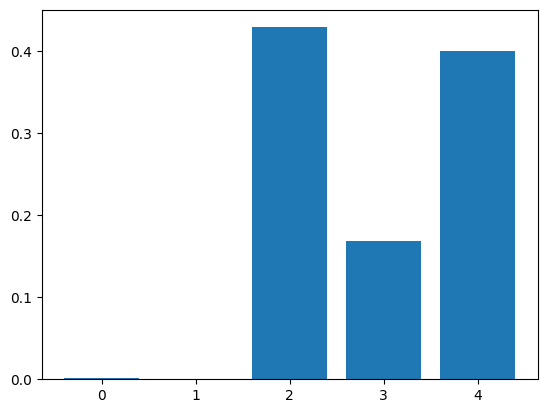

,variant,prob
3,0,0.0012
1,2,0.4292
2,3,0.1691
0,4,0.4005


In [3]:

results = defaultdict(int)
for i in tqdm(range(10000)):
    i_res = cups.grade()
    i_var = int(i_res.iloc[0]['name'])
    results[i_var] += 1

variants_proba_current = pd.DataFrame(results.items(), columns=['variant', 'prob'])
variants_proba_current['prob'] = variants_proba_current['prob']/sum(variants_proba_current['prob'])
variants_proba_current = variants_proba_current.sort_values('variant')

plt.bar(variants_proba_current['variant'], variants_proba_current['prob'], align='center')

plt.show()
variants_proba_current

In [4]:

fig = px.violin(cups.history, y="value", x="option", box=True, points="all",
          hover_data=cups.history.columns)
fig.show()

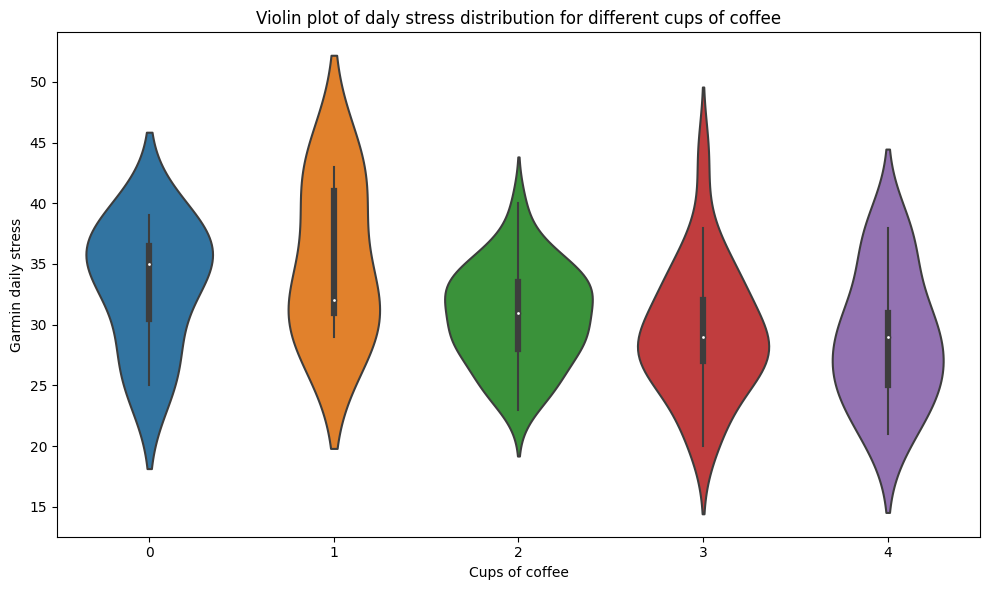

In [5]:

grouped_data = [group['value'].values for name, group in cups.history.groupby('option')]
fix, ax = plt.subplots(figsize=(10, 6))
sns.violinplot(x='option', y='value', data=cups.history, ax=ax)
ax.set_title('Violin plot of daly stress distribution for different cups of coffee')
ax.set_xlabel('Cups of coffee')
ax.set_ylabel('Garmin daily stress')
plt.tight_layout()
plt.show()

# Какой выход из МЦК утром?
* Садиться в ту дверь, которая кажется ближе к выходу
* считать от выхода на платформу до выхода из крутящихся дверей офиса


In [6]:
morning_exit = HandsTable(options_list=["мцк","мцд эскалатор", "мцд пешком"], minimize=True)
# 3 мцк
# 6 мцд эскалатор
morning_exit.update_hands("мцк", '0:08:03.7') # вторник 19 ноября
morning_exit.update_hands("мцд эскалатор", '0:08:40') # среда 20 ноября
morning_exit.update_hands("мцк", '0:09:23.4') # mon 25 ноября
morning_exit.update_hands("мцд эскалатор", '0:07:46.5') # вторник 26 ноября
morning_exit.update_hands("мцд эскалатор", '0:07:27.9') # среда 27 ноября
morning_exit.update_hands("мцк", '0:09:11') # пятница 29 ноября
morning_exit.update_hands("мцд эскалатор", '0:08:17.6') # понедельник 2 декабря
morning_exit.update_hands("мцд эскалатор", '0:08:28.4') # вторник 3 декабря
morning_exit.update_hands("мцд эскалатор", '0:08:28.4') # wed 4 dec
morning_exit.update_hands("мцд эскалатор", '0:07:26') # th 5 dec
morning_exit.update_hands("мцд эскалатор", '0:08:46.4') # fr 6 dec
morning_exit.update_hands("мцд эскалатор", '0:08:51.5') # mon 9 dec
morning_exit.update_hands("мцд эскалатор", '0:07:54.6') # th 12 dec
morning_exit.update_hands("мцд эскалатор", '0:08:05.6') # fr 13 dec
morning_exit.update_hands("мцд эскалатор", '0:08:37') # пн 16 dec
morning_exit.update_hands("мцд эскалатор", '0:07:38.9') # tue 17 dec
morning_exit.update_hands("мцк", '0:08:59.2') # wed 18 dec
morning_exit.update_hands("мцд эскалатор", '0:07:27.7') # th 19 dec
morning_exit.update_hands("мцд эскалатор", '0:07:56.5') # fr 20 dec
morning_exit.update_hands("мцд эскалатор", '0:07:26.32') # mon 23 dec
morning_exit.update_hands("мцд эскалатор", '0:09:09.3') # tue 24 dec
morning_exit.update_hands("мцд эскалатор", '0:07:53.2') # wed 25 dec
morning_exit.update_hands("мцд эскалатор", '0:07:32.9') # thr 26 dec
morning_exit.update_hands("мцд эскалатор", '0:07:06.4') # thr 09 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:12.6') # fr 10 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:39.3') # mon 13 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:54.4') # tue 14 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:47.1') # wed 15 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:24.0') # thr 16 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:15.4') # fr 17 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:04.1') # mon 20 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:52.4') # tue 21 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:40.0') # wed 22 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:21.0') # thr 23 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:50.5') # fr 24 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:11.1') # mon 27 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:07:21.52') # tue 28 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:26.8') # wed 29 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:01.8') # thr 30 jan 2025
morning_exit.update_hands("мцд эскалатор", '0:08:14.0') # mon 3 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:07:51.4') # tue 4 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:07:53') # wed 5 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:08:05') # thr 6 feb 2025
morning_exit.update_hands("мцд пешком", '0:08:26.8') # fr 7 feb 2025
morning_exit.update_hands("мцд пешком", '0:08:27.8') # monday 10 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:07:58.9') # tue 11 feb 2025
morning_exit.update_hands("мцд пешком", '0:08:24.6') # wed 12 feb 2025
morning_exit.update_hands("мцд пешком", '0:07:47.1') # thr 13 feb 2025
morning_exit.update_hands("мцд эскалатор", '0:07:54.1') # fr 15 feb 2025

morning_exit.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
1,мцд эскалатор,7.975423,41.0,21.0,4.843012,4.568155,8.026939,0.467875,8.943956
2,мцд пешком,8.276250,4.0,2.5,0.661629,3.600145,7.985852,0.527036,9.018823
0,мцк,8.905417,4.0,2.5,1.015287,1.873474,8.467818,0.730594,9.899756


In [7]:
fig = px.violin(morning_exit.history, y="value", x="option", box=True, points="all",
          hover_data=cups.history.columns)
fig.show()

# Какой вход в МЦК вечером?
* Садиться в ту дверь, которая кажется ближе к выходу
* считать от выхода из крутящихся дверей до посадки в поезд


In [8]:
evening_entrance = HandsTable(options_list=["мцк","мцд эскалатор", "мцд пешком"], minimize=True)
# 3 мцк
# 6 мцд эскалатор
evening_entrance.update_hands("мцд эскалатор", '0:08:03.7') # четверг 21 ноября
evening_entrance.update_hands("мцк", '0:11:14') # четверг 28 ноября
evening_entrance.update_hands("мцд эскалатор", '0:15:47.8') # понедельник 2 декабря
evening_entrance.update_hands("мцк", '0:11:03') # tue 3 dec
evening_entrance.update_hands("мцк", '0:14:29.3') # wed 4 dec
evening_entrance.update_hands("мцк", '0:12:05') # fr 06 dec
evening_entrance.update_hands("мцк", '0:13:53') # mon 09 dec
evening_entrance.update_hands("мцд эскалатор", '0:10:14') # fr 13 декабря
evening_entrance.update_hands("мцк", '0:09:31.7') # tue 17 dec
evening_entrance.update_hands("мцк", '0:08:33') # wed 18 dec
evening_entrance.update_hands("мцд эскалатор", '0:09:51.9') # th 19 dec
evening_entrance.update_hands("мцд эскалатор", '0:09:16.1') # mon 23 dec
evening_entrance.update_hands("мцд эскалатор", '0:09:31.7') # tue 24 dec
evening_entrance.update_hands("мцк", '0:08:19.6') # wed 18 dec
evening_entrance.update_hands("мцд эскалатор", '0:09:18.6') # th 9 jan
evening_entrance.update_hands("мцк", '0:08:11.9') # fr 10 jan
evening_entrance.update_hands("мцд эскалатор", '0:10:50') # mon 13 jan
evening_entrance.update_hands("мцд эскалатор", '0:11:15') # tue 14 jan
evening_entrance.update_hands("мцк", '0:12:08') # wed 15 jan
evening_entrance.update_hands("мцк", '0:10:13') # mon 20 jan
evening_entrance.update_hands("мцд эскалатор", '0:11:40') # tue 21 jan
evening_entrance.update_hands("мцк", '0:15:48') # wed 22 jan
evening_entrance.update_hands("мцд эскалатор", '0:09:34.7') # thr 23 jan
evening_entrance.update_hands("мцд пешком", '0:10:45') # thr 6 feb
evening_entrance.update_hands("мцд пешком", '0:12:01') # fr 7 feb
evening_entrance.update_hands("мцд пешком", '0:10:34') # monday 10 feb
evening_entrance.update_hands("мцд пешком", '0:09:08.2') # thr 13 feb
evening_entrance.update_hands("мцд пешком", '0:09:57.6') # fr 14 feb

evening_entrance.grade()

,name,mu,Te,alpha,beta,tau,theta,SD,var95
2,мцд пешком,10.486000,5.0,3.0,2.758260,2.946202,10.825950,0.582598,11.967820
1,мцд эскалатор,10.490152,11.0,6.0,21.117423,0.285493,10.484590,1.871554,14.152770
0,мцк,11.290972,12.0,6.5,34.899532,0.296609,11.386053,1.836148,14.984836


In [9]:
fig = px.violin(evening_entrance.history, y="value", x="option", box=True, points="all",
          hover_data=cups.history.columns)
fig.show()